In [1]:
import hvplot.pandas
import matplotlib.pyplot as plt
import pandas as pd
import requests

from geopy.exc import GeocoderUnavailable
from geopy.geocoders import Nominatim
from IPython.display import Image
from IPython.display import display
from pathlib import Path
from scipy import stats

In [2]:
# Load in the relevant datasets

# DALYs by country
# DALYs are Disabililty Adjusted Life Years. This refers to the average number of years a citizen's life is shortened due to a disability (i.e. mental illness).
dalys_df = pd.read_csv(Path('mental_health_dataset', 'mental-and-substance-use-as-share-of-disease.csv'))
dalys_df = dalys_df.rename(columns={'DALYs (Disability-Adjusted Life Years) - Mental disorders - Sex: Both - Age: All Ages (Percent)' : 'DALYs'})

# Prevalance of mental illness by country as a percentage of the country's population
# The illnesses observed are schizophrenia, bipolar disorder, eating disorders, anxiety disorders, drug use disorders,depressive disorders, and alcohol use disorders
disease_df = pd.read_csv(Path('mental_health_dataset', 'prevalence-by-mental-and-substance-use-disorder.csv'))
disease_df = disease_df.rename(columns={
    'Prevalence - Schizophrenia - Sex: Both - Age: Age-standardized (Percent)' : 'Schizophrenia',
    'Prevalence - Bipolar disorder - Sex: Both - Age: Age-standardized (Percent)' : 'Bipolar disorder',
    'Prevalence - Eating disorders - Sex: Both - Age: Age-standardized (Percent)' : 'Eating disorders',
    'Prevalence - Anxiety disorders - Sex: Both - Age: Age-standardized (Percent)' : 'Anxiety disorders',
    'Prevalence - Drug use disorders - Sex: Both - Age: Age-standardized (Percent)' : 'Drug use disorders',
    'Prevalence - Depressive disorders - Sex: Both - Age: Age-standardized (Percent)' : 'Depressive disorders',
    'Prevalence - Alcohol use disorders - Sex: Both - Age: Age-standardized (Percent)' : 'Alcohol use disorders'
})

# Data Cleaning

In [3]:
dalys_df.dropna()
dalys_df.describe().loc[['min', 'max']].astype(float)

,Year,DALYs
min,1990.0,0.215647
max,2019.0,13.761517


## Observations
-  All N/A value have been removed from the DALYs dataset.<br>
-  The minimum and maximum years fall within the expect range (1990-2019).<br>
-  The minimum DALYs is greater than 0. Mental illness is not expected to prolong life. <br>
-  The maximum DALYs is below 14 years. This value is expected to be lower than a human lifespan.

In [4]:
disease_df.dropna()
disease_df.describe().loc[['min', 'max']].astype(float)

,Year,Schizophrenia,Bipolar disorder,Eating disorders,Anxiety disorders,Drug use disorders,Depressive disorders,Alcohol use disorders
min,1990.0,0.191621,0.189344,0.045425,1.974823,0.225471,1.640902,0.319900
max,2019.0,0.506018,1.676204,1.136541,9.015948,3.699504,7.688213,4.698694


## Observations
-  All N/A value have been removed from the diseases dataset.<br>
-  The minimum and maximum years fall within the expect range (1990-2019).<br>
-  The value for each disorder represents a percentage of a country's population. The lowest values should be greater than or (in a perfect world) equal to zero. The greatest values should not be a majority of the population of a country. 9.015948% seems to be a reasonable maximum value. This is the opinion of a data analyst, not a mental health professional.

# Question #1 - Is there a difference in mental health among geographical regions?

In [5]:
# Perform geographic analysis. This will require coordinates for each country which can be queried through the geopy library.
# This can take a while, so only run this cell if you don't already have the data saved locally.

# Country code 'NA' exists so it should be removed from the na_values list
na_values = [' ', '#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-NaN', '-nan', '1.#IND', '1.#QNAN', '<NA>', 
             'N/A', 'NULL', 'NaN', 'None', 'n/a', 'nan', 'null ']

# Country codes are necessary to differentiate between 2 similarly named regions (i.e. Georgia the state and country)
country_codes_df = pd.read_csv(Path('geodata', 'country_codes.csv'), na_values = na_values, keep_default_na = False)

# Get the list of countries from the DALYs dataset
geo_df = pd.DataFrame(dalys_df['Entity'].unique(), columns=['Entity'])

# Merge countries with codes
geo_df = geo_df.merge(country_codes_df, on='Entity')

# Query for coordinates
geolocator = Nominatim(user_agent='data_science_student_project')
lat = []
lon = []

for country, code in zip(geo_df['Entity'], geo_df['Code']):
    print(f'Retrieving geodata for {country}...')
    try:
        # Get the geodata
        geodata = geolocator.geocode(country, country_codes=code)

        # Pull out the latitude and longitude
        try:
            lat.append(geodata.latitude)
        except AttributeError:
            lat.append('N/A')
            print(f'Latitude not for {country}.')
        try:
            lon.append(geodata.longitude)
        except AttributeError:
            lon.append('N/A')
            print(f'Longitude not for {country}.')
    except (TimeoutError, GeocoderUnavailable):
        lat.append('N/A')
        print(f'Latitude not for {country}.')
        lon.append('N/A')
        print(f'Longitude not for {country}.')

print('''
*******************************
Geodata retrieval complete!
*******************************''')

Retrieving geodata for Afghanistan...
Retrieving geodata for Albania...
Retrieving geodata for Algeria...
Retrieving geodata for American Samoa...
Latitude not for American Samoa.
Longitude not for American Samoa.
Retrieving geodata for Andorra...
Retrieving geodata for Angola...
Retrieving geodata for Antigua and Barbuda...
Retrieving geodata for Argentina...
Retrieving geodata for Armenia...
Retrieving geodata for Australia...
Retrieving geodata for Austria...
Retrieving geodata for Azerbaijan...
Retrieving geodata for Bahamas...
Retrieving geodata for Bahrain...
Retrieving geodata for Bangladesh...
Retrieving geodata for Barbados...
Retrieving geodata for Belarus...
Retrieving geodata for Belgium...
Retrieving geodata for Belize...
Retrieving geodata for Benin...
Retrieving geodata for Bermuda...
Retrieving geodata for Bhutan...
Retrieving geodata for Bolivia...
Retrieving geodata for Bosnia and Herzegovina...
Retrieving geodata for Botswana...
Retrieving geodata for Brazil...
Retri

In [6]:
# Save geodata for later use. It is easier to read the data from a local .csv than to perform all the geodata queries again.
pd.DataFrame({
    'Entity' : geo_df['Entity'],
    'Latitude' : lat,
    'Longitude' : lon
}).to_csv(Path('geodata', 'coordinates.csv'), index=False)

In [7]:
# Load geodata if not already loaded into the notebook
geo_df = pd.read_csv(Path('geodata', 'coordinates.csv'))

In [8]:
# Merge geodata with DALYs data
geo_df = geo_df.merge(dalys_df, on='Entity')
geo_df = geo_df.dropna()
geo_df

,Entity,Latitude,Longitude,Code,Year,DALYs
0,Afghanistan,33.768006,66.238514,AFG,1990,1.696670
1,Afghanistan,33.768006,66.238514,AFG,1991,1.734281
2,Afghanistan,33.768006,66.238514,AFG,1992,1.791189
3,Afghanistan,33.768006,66.238514,AFG,1993,1.776779
4,Afghanistan,33.768006,66.238514,AFG,1994,1.712986
...,...,...,...,...,...,...
6055,Zimbabwe,-18.455496,29.746841,ZWE,2015,2.193166
6056,Zimbabwe,-18.455496,29.746841,ZWE,2016,2.279813
6057,Zimbabwe,-18.455496,29.746841,ZWE,2017,2.364265
6058,Zimbabwe,-18.455496,29.746841,ZWE,2018,2.472949


In [9]:
# Create a map to visually inspect for regional trends. We will arbitrarily use the latest year in the dataset, 2019.
year = 2019
dalys_map = geo_df[geo_df['Year'] == year].hvplot.points(
    'Longitude',
    'Latitude',
    geo = True,
    tiles = 'OSM',
    frame_width = 700,
    frame_height = 500,
    size = 'DALYs',
    color = 'Entity',
    alpha = 0.5,
    scale = 6,
    title = f'DALYs in {year} by Country (indicated by dot size)'
)
hvplot.save(dalys_map, Path('media', 'dalys_map.html'))
dalys_map

c:\Users\Matthew\anaconda3\envs\dev\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Longitude,Latitude]   (Entity,DALYs)

## Observations
Africa has noticeably smaller DALYs than the Americas, Europe, and the Middle East. Let's dig into the statistics to find out more.

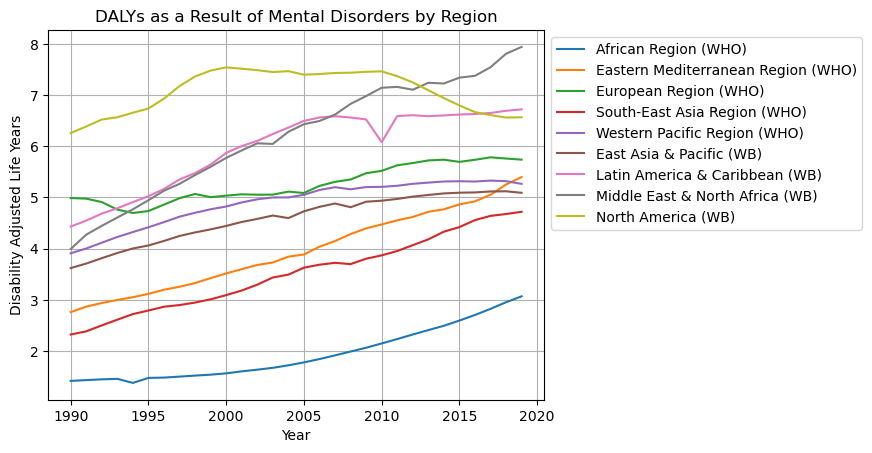

,count,mean,std,min,25%,50%,75%,max
Entity,,,,,,,,
African Region (WHO),30.0,1.940398,0.515247,1.378090,1.506294,1.750572,2.301569,3.069142
South-East Asia Region (WHO),30.0,3.517538,0.726899,2.323155,2.910889,3.560689,4.039802,4.720232
Eastern Mediterranean Region (WHO),30.0,3.956516,0.780661,2.760770,3.274324,3.865009,4.602252,5.398671
East Asia & Pacific (WB),30.0,4.591208,0.469133,3.620257,4.265443,4.688283,5.004946,5.120409
Western Pacific Region (WHO),30.0,4.897136,0.437364,3.910267,4.643972,5.026614,5.256426,5.329064
European Region (WHO),30.0,5.258247,0.358108,4.697142,4.992851,5.100676,5.660788,5.783628
Latin America & Caribbean (WB),30.0,5.970586,0.759604,4.431947,5.382909,6.301551,6.588916,6.720816
Middle East & North Africa (WB),30.0,6.192522,1.133270,3.993599,5.308950,6.356445,7.155375,7.939938
North America (WB),30.0,7.065665,0.416479,6.257477,6.658154,7.211062,7.445974,7.540770


In [10]:
# The DALYs dataset also includes regional data, which we will extract, plot, and analyze below.
regions = ['African Region (WHO)', 'Eastern Mediterranean Region (WHO)', 'European Region (WHO)', 'South-East Asia Region (WHO)', 
           'Western Pacific Region (WHO)', 'East Asia & Pacific (WB)', 'Latin America & Caribbean (WB)', 'Middle East & North Africa (WB)', 
           'North America (WB)']
regions_df = pd.DataFrame()

for r in regions:
    df = dalys_df[dalys_df['Entity'] == r]
    regions_df = pd.concat([regions_df, df])
    plt.plot(df['Year'], df['DALYs'])

plt.title('DALYs as a Result of Mental Disorders by Region')
plt.xlabel('Year')
plt.ylabel('Disability Adjusted Life Years')
plt.legend(regions, bbox_to_anchor=(1, 1))
plt.grid()
plt.savefig(Path('media', 'dalys_by_region.png'), bbox_inches="tight")
plt.show()

regions_stats = regions_df.groupby('Entity')['DALYs'].describe().sort_values('mean')
regions_stats.to_csv(Path('media', 'dalys_stats.csv'))
regions_stats

## Observations
-  The population of the African region clearly experiences lower DALYs than all other regions, with the smallest mean, minimum value, and maxiumum value.<br>
-  The population of North America was the most mentally unhealthy starting at 1990, but begins to recover after 2010. The DALYs dip below Latin America and the Caribbean in 2017 before leveling off.<br>
-  The DALYs for Latin America and the Caribbean appear to keep pace with the Middle East and North Africa, but then level out in 2006 while the latter region's DALYs continue to grow. This diversion could be worth further investigation.<br>
-  The European region DALYs had the smallest standard deviation over the timespan, indicating the smallest fluctuation in mental health.<br>
-  Across all regions, mental health appears to be **trending for the worse**.

# Question #2 - Are wealthier countries mentally healthier than others?

In [ ]:
# For this analysis, we will look at the top and bottom 5 wealthiest countries.
countries_of_interest = ['United States', 'China', 'Japan', 'Germany', 'United Kingdom',    # Wealthiest countries
                         'Comoros', 'Djibouti', 'Guinea-Bissau', 'Lesotho', 'Suriname']     # Poorest countries

for c in countries_of_interest:
    df = dalys_df[dalys_df['Entity'] == c]
    plt.plot(df['Year'], df['DALYs'])

plt.legend(countries_of_interest)
plt.title('DALYs as a Result of Mental Disorders by Country')
plt.xlabel('Year')
plt.ylabel('Disability Adjusted Life Years')
plt.legend(countries_of_interest, bbox_to_anchor=(1, 1))
plt.grid()
plt.show()

In [ ]:
# For this analysis, we will look at the distribution of mental illnesses within our countries of interest.
diseases = ['Schizophrenia', 'Bipolar disorder', 'Eating disorders', 'Anxiety disorders','Drug use disorders','Depressive disorders', 'Alcohol use disorders']

for c in countries_of_interest:
    df = disease_df[disease_df['Entity'] == c]
    for d in diseases:
        plt.plot(df['Year'], df[d], alpha=0.8)
    plt.title(c)
    plt.xlabel('Year')
    plt.ylabel('Percent of Population with Disorder')
    plt.legend(diseases, bbox_to_anchor=(1, 1))
    plt.grid()
    plt.show()

## Observations
Across the board, the two disorders that are affecting the highest population in each listed countries are Anxiety and Depressive disorders. The two disorders that are least affecting are Eating disorders and Schizophrenia. Alcohol disorders fall in the middle in every graph.
United Kingdoms is the only country where Bipolar disorders are above 1%. United States is the only country where drug and alcohol use is above 2%.

In [ ]:
disease_df.head()

In [ ]:
#calculate population average for schizohprenia for US
united_states_df = disease_df.loc[disease_df['Entity'] == 'United States']

us_schizophrenia_mean = united_states_df['Schizophrenia'].mean()
us_schizophrenia_mean

In [ ]:
#calculate population average for schizohprenia for UK
united_kingdom_df = disease_df[disease_df['Entity'] == 'United Kingdom']

uk_schizophrenia_mean = united_kingdom_df['Schizophrenia'].mean()
uk_schizophrenia_mean


In [ ]:
#Calculate Independent (Two Sample) t-test
stats.ttest_ind(united_states_df['Schizophrenia'], united_kingdom_df['Schizophrenia'], equal_var=False)

Based on this t-test it is safe to say that the average suffering with Schzophrenia in the United States is higher than the United Kingdom.

In [ ]:
us_bipolar_disorder_mean = united_states_df['Bipolar disorder'].mean()
us_bipolar_disorder_mean

In [ ]:
uk_bipolar_disorder_mean = united_kingdom_df['Bipolar disorder'].mean()
uk_bipolar_disorder_mean

In [ ]:
stats.ttest_ind(united_states_df['Bipolar disorder'], united_kingdom_df['Bipolar disorder'], equal_var=False)

The population percentage in the UK suffering from bipolar disorder is higher than the population percentage in the US.

In [ ]:
us_eating_disorder_mean = united_states_df['Eating disorders'].mean()
us_eating_disorder_mean

In [ ]:
uk_eating_disorder_mean = united_kingdom_df['Eating disorders'].mean()
uk_eating_disorder_mean

In [ ]:
stats.ttest_ind(united_states_df['Eating disorders'], united_kingdom_df['Eating disorders'], equal_var=False)

The population percentage in the US suffering from eating disorders is higher than the UK.

In [ ]:
us_anxiety_disorder_mean = united_states_df['Anxiety disorders'].mean()
us_anxiety_disorder_mean

In [ ]:
uk_anxiety_disorder_mean = united_kingdom_df['Anxiety disorders'].mean()
uk_anxiety_disorder_mean

In [ ]:
stats.ttest_ind(united_states_df['Anxiety disorders'], united_kingdom_df['Anxiety disorders'], equal_var=False)

The population percentage in the US suffering from Anxiety disorders is higher than the UK.

In [ ]:
us_drug_use_mean = united_states_df['Drug use disorders'].mean()
us_drug_use_mean

In [ ]:
uk_drug_use_mean = united_kingdom_df['Drug use disorders'].mean()
uk_drug_use_mean

In [ ]:
stats.ttest_ind(united_states_df['Drug use disorders'], united_kingdom_df['Drug use disorders'], equal_var=False)

The population percentage in the US suffering from Drug use disorders is higher than the UK.

In [ ]:
us_depressive_disorder_mean = united_states_df['Depressive disorders'].mean()
us_depressive_disorder_mean

In [ ]:
uk_depressive_disorder_mean = united_kingdom_df['Depressive disorders'].mean()
uk_depressive_disorder_mean

In [ ]:
stats.ttest_ind(united_states_df['Depressive disorders'], united_kingdom_df['Depressive disorders'], equal_var=False)

The population percentage in the US suffering from Depressive disorders is higher than the UK.

In [ ]:
us_alcohol_use_mean = united_states_df['Alcohol use disorders'].mean()
us_alcohol_use_mean 

In [ ]:
uk_alcohol_use_mean = united_kingdom_df['Alcohol use disorders'].mean()
uk_alcohol_use_mean

In [ ]:
stats.ttest_ind(united_states_df['Depressive disorders'], united_kingdom_df['Depressive disorders'], equal_var=False)

The population percentage in the UK suffering from Alcohol use is higher than the US.

In [ ]:
#perform some t-tests for DALY dataset
daly_united_states_df = dalys_df.loc[dalys_df['Entity'] == 'United States']
daly_united_kingdom_df = dalys_df.loc[dalys_df['Entity'] == 'United Kingdom']

us_daly_mean = daly_united_states_df['DALYs (Disability-Adjusted Life Years) - Mental disorders - Sex: Both - Age: All Ages (Percent)'].mean()
us_daly_mean

In [ ]:
uk_daly_mean = daly_united_kingdom_df['DALYs (Disability-Adjusted Life Years) - Mental disorders - Sex: Both - Age: All Ages (Percent)'].mean()
uk_daly_mean

In [ ]:
stats.ttest_ind(daly_united_states_df['DALYs (Disability-Adjusted Life Years) - Mental disorders - Sex: Both - Age: All Ages (Percent)'], daly_united_kingdom_df['DALYs (Disability-Adjusted Life Years) - Mental disorders - Sex: Both - Age: All Ages (Percent)'], equal_var=False)

The Disability-Adjusted Life Years is higher in the US than the UK.

## Analysis Disorder Trends Year - over - Year

In [ ]:
trend = pd.DataFrame(columns = ['Country','Diesces','Slope','R-Value'])

for c in countries:
    df = disease_df[disease_df['Entity'] == c]
    for d in diseases:
        (slope, intercept, rvalue, pvalue, stderr) = stats.linregress(df['Year'], df[d])
        temp = pd.DataFrame([{'Country': c, 'Diesces': d, 'Slope': slope, 'R-Value': rvalue}])
        trend= pd.concat([trend, temp])  

trend_signifin = trend[abs(trend['R-Value']) >= .7  ]

In [ ]:
# Top correlation
trend2 = trend_signifin.sort_values(['R-Value'], ascending = False)
trend2.head()

In [ ]:
# Top Increasing disorders Diesces and Country
trend3 = trend_signifin.sort_values(['Slope'], ascending = False)
trend3.head()

In [ ]:
# Top Decreasing disorders Diesces and Country
trend3.tail()

In [ ]:
plt.bar(trend3['Country'] + trend3['Diesces']  ,trend3['Slope'])
plt.xticks(rotation = 90 )
plt.ylabel('Year over Year Change')
plt.title('Trend of % of Population with Disorders by Country')
plt.show()

## Increasing Disorders are:
#    1. United States Drug Disorders
#    2. United Kingdom Alchol Discordes
#    3. United Kingdom Drug use disorders
#    4. Germany	Depressive disorders
#     5. Lesotho	Depressive disorders	

## Decreasing Disorders:
# 1. China	Depressive disorders	
# 2. Japan	Anxiety disorders
# 3. United States	Alcohol use disorders
# 4. China	Anxiety disorders
# 5. Germany	Alcohol use disorders	

In [ ]:
# Are disorders generatry increasing or decreasing
trend3[trend3['Slope']>0]['Slope'].count()/ trend3['Slope'].count()

# We hope these cat pictures can make you feel better!

In [ ]:
#create function for cat displaying
url = f'https://api.thecatapi.com/v1/images/search'
def print_cat():
    response = requests.request('GET', url)
    if response.status_code ==200:
        cat = response.json()
        cat_url = cat[0]['url']
        display(Image(url = cat_url))
    else:
        print('Could not get picture of cat!')

In [ ]:
for num in range(1,5):
    print_cat()